In [44]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import seaborn as sns
from datasets import *

%matplotlib inline


import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split


warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 40)
random_state = 20180415

#### Importing graduation rates

In [45]:
excel_file = 'graduation_rates_public_school_2010_2011.xlsx'
df1 = pd.read_excel(excel_file,sheet_name=0)

#### Importing school progress reports and class size stats

In [46]:
df2 = pd.read_csv('2019_2010_schools_progress.csv')
classsize = pd.read_csv('class_size.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 17 columns):
DBN                                     1677 non-null object
DISTRICT                                1677 non-null int64
SCHOOL                                  1677 non-null object
PRINCIPAL                               1676 non-null object
PROGRESS REPORT TYPE                    1677 non-null object
SCHOOL LEVEL*                           1677 non-null object
PEER INDEX*                             1595 non-null float64
2009-2010 OVERALL GRADE                 1534 non-null object
2009-2010 OVERALL SCORE                 1534 non-null float64
2009-2010 ENVIRONMENT CATEGORY SCORE    1534 non-null float64
2009-2010 ENVIRONMENT GRADE             1534 non-null object
2009-2010 PERFORMANCE CATEGORY SCORE    1534 non-null float64
2009-2010 PERFORMANCE GRADE             1534 non-null object
2009-2010 PROGRESS CATEGORY SCORE       1534 non-null float64
2009-2010 PROGRESS GRADE           

In [48]:
df2 = df2.dropna(subset=['2009-2010 OVERALL GRADE'])
overall_grades = ['overall_grade_' + grade for grade in df2['2009-2010 OVERALL GRADE'].unique()]
for grade in df2['2009-2010 OVERALL GRADE'].unique():
    df2['overall_grade_' + grade] = (df2['2009-2010 OVERALL GRADE']==grade)*1

df2 = df2.dropna(subset=['2009-2010 ENVIRONMENT GRADE'])
overall_grades = ['environment_grade_' + grade for grade in df2['2009-2010 ENVIRONMENT GRADE'].unique()]
for grade in df2['2009-2010 ENVIRONMENT GRADE'].unique():
    df2['environment_grade_' + grade] = (df2['2009-2010 ENVIRONMENT GRADE']==grade)*1

the_grade = '2009-2010 PERFORMANCE GRADE'
df2 = df2.dropna(subset=[the_grade])
overall_grades = ['performance_grade_' + grade for grade in df2[the_grade].unique()]
for grade in df2[the_grade].unique():
    df2['performance_grade_' + grade] = (df2[the_grade]==grade)*1

the_grade = '2009-2010 PROGRESS GRADE'
df2 = df2.dropna(subset=[the_grade])
overall_grades = ['progress_grade_' + grade for grade in df2[the_grade].unique()]
for grade in df2[the_grade].unique():
    df2['progress_grade_' + grade] = (df2[the_grade]==grade)*1



df2.columns


Index(['DBN', 'DISTRICT', 'SCHOOL', 'PRINCIPAL', 'PROGRESS REPORT TYPE',
       'SCHOOL LEVEL*', 'PEER INDEX*', '2009-2010 OVERALL GRADE',
       '2009-2010 OVERALL SCORE', '2009-2010 ENVIRONMENT CATEGORY SCORE',
       '2009-2010 ENVIRONMENT GRADE', '2009-2010 PERFORMANCE CATEGORY SCORE',
       '2009-2010 PERFORMANCE GRADE', '2009-2010 PROGRESS CATEGORY SCORE',
       '2009-2010 PROGRESS GRADE', '2009-2010 ADDITIONAL CREDIT',
       '2008-09 PROGRESS REPORT GRADE', 'overall_grade_C', 'overall_grade_A',
       'overall_grade_B', 'overall_grade_D', 'overall_grade_F',
       'environment_grade_B', 'environment_grade_A', 'environment_grade_C',
       'environment_grade_F', 'environment_grade_D', 'performance_grade_D',
       'performance_grade_C', 'performance_grade_A', 'performance_grade_F',
       'performance_grade_B', 'progress_grade_B', 'progress_grade_A',
       'progress_grade_D', 'progress_grade_F', 'progress_grade_C'],
      dtype='object')

#### Merging all datasets based on DBN (unique identifier for schools)

In [49]:
df3 = pd.merge(df1, df2, on='DBN')
df3 = pd.merge(df3, classsize, on='DBN')

In [50]:
df3.head()

,DBN,School Name,Category,Cohort Year,Cohort,Cohort Total,Grads Total,Grads Percent of Cohort,Regents Total,Regents Percent of Cohort,Regents Percent of Grads,Advanced Regents Total,Advanced Regents Percent of Cohort,Advanced Regents Percent of Grads,Regents without Advanced Total,Regent without Advanced Percent of Cohort,Regents without Advanced Percent of Grads,Local Total,Local Percent of Cohort,Local Percent of Grads,...,overall_grade_D,overall_grade_F,environment_grade_B,environment_grade_A,environment_grade_C,environment_grade_F,environment_grade_D,performance_grade_D,performance_grade_C,performance_grade_A,performance_grade_F,performance_grade_B,progress_grade_B,progress_grade_A,progress_grade_D,progress_grade_F,progress_grade_C,min,max,mean
0,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538
1,01M292,Orchard Collegiate Academy,All Students,2011,4 year August,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,11.0,26.0,18.961538
2,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.623,26,42.623,100,1,1.63934,3.84615,25,40.9836,96.1538,0,0,0,...,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538
3,01M292,Orchard Collegiate Academy,All Students,2010,4 year August,61,26,42.623,26,42.623,100,1,1.63934,3.84615,25,40.9836,96.1538,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,11.0,26.0,18.961538
4,01M292,Orchard Collegiate Academy,All Students,2011,4 year June,73,46,63.0137,41,56.1644,89.1304,0,0,0,41,56.1644,89.1304,5,6.84932,10.8696,...,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,11.0,26.0,18.961538


#### Converting columns to numeric

In [51]:
cols = ['Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min']
df3[cols] = df3[cols].apply(pd.to_numeric,errors='coerce')
df3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4115 entries, 0 to 4114
Data columns (total 63 columns):
DBN                                          4115 non-null object
School Name                                  4115 non-null object
Category                                     4115 non-null object
Cohort Year                                  4115 non-null int64
Cohort                                       4115 non-null object
Cohort Total                                 4115 non-null int64
Grads Total                                  4115 non-null object
Grads Percent of Cohort                      4115 non-null object
Regents Total                                4115 non-null object
Regents Percent of Cohort                    4100 non-null float64
Regents Percent of Grads                     4115 non-null object
Advanced Regents Total                       4115 non-null object
Advanced Regents Percent of Cohort           4100 non-null float64
Advanced Regents Percent of Grads  

#### Choosing features and splitting data into trainingn, test and holdout

In [85]:
features = (['DISTRICT', 'PEER INDEX*', '2009-2010 ENVIRONMENT CATEGORY SCORE', '2009-2010 PERFORMANCE CATEGORY SCORE', '2009-2010 PROGRESS CATEGORY SCORE','Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min'])

##features = (['Grads Percent of Cohort'])

model_df = df3[(features + ['Grads Percent of Cohort'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['Grads Percent of Cohort'], test_size=0.1,
    random_state=random_state)

train_df['Grads Percent of Cohort'] = y_train
holdout_df['Grads Percent of Cohort'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df['Grads Percent of Cohort'].mean())
print(holdout_df.shape[0], holdout_df['Grads Percent of Cohort'].mean())





3690 74.41229264232112
410 75.32638559816834


In [86]:
model_df.shape

(4100, 14)

In [87]:
train_df.shape

(3690, 14)

In [88]:
holdout_df.shape
holdout_df

,index,DISTRICT,PEER INDEX*,2009-2010 ENVIRONMENT CATEGORY SCORE,2009-2010 PERFORMANCE CATEGORY SCORE,2009-2010 PROGRESS CATEGORY SCORE,Regents Percent of Cohort,Advanced Regents Percent of Cohort,Regent without Advanced Percent of Cohort,Dropout Percent of Cohort,mean,max,min,Grads Percent of Cohort
0,3147,22,3.27,12.5,17.2,44.5,100.000000,45.098038,54.901962,0.000000,25.570968,34.0,18.0,100
1,2266,13,2.27,8.1,14.6,28.6,12.244898,0.000000,12.244898,38.775509,24.394444,32.0,16.0,14.2857
2,3431,25,2.45,8.5,10.5,29.2,54.304634,12.450331,41.854305,15.231788,24.097727,33.8,5.0,57.351
3,47,1,2.21,11.1,14.7,44.1,88.636360,0.000000,88.636360,7.954545,24.021739,33.0,14.7,90.9091
4,998,6,2.22,11.1,19.8,44.5,67.955803,0.000000,67.955803,16.574585,21.676923,33.0,6.0,75.1381
5,3642,28,2.57,12.4,10.4,32.8,66.143791,13.986928,52.156864,8.235294,27.956757,36.0,12.5,68.4967
6,2646,17,2.35,5.2,14.9,24.5,62.857143,0.000000,62.857143,4.285714,24.636842,32.0,15.5,68.5714
7,2755,17,3.23,11.3,19.2,45.7,98.780487,7.317073,91.463417,1.219512,23.723810,33.5,10.0,98.7805
8,1652,10,1.85,11.3,17.0,38.1,53.424656,15.068493,38.356163,13.698630,28.385714,33.5,24.0,56.1644
9,1618,10,2.58,13.0,25.0,59.3,85.245903,0.000000,85.245903,6.557377,26.696296,33.0,6.0,91.8033


#### Linear Regression with Cross Validation

In [89]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [90]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'Grads Percent of Cohort'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = mean_squared_error(train_df.loc[test,'Grads Percent of Cohort'], y_predicted)
        results.append(accuracy)
        print(classifier.score(train_df.loc[train, features],train_df.loc[train, 'Grads Percent of Cohort']))
    
    return np.mean(results), np.std(results)

In [91]:
reg = LinearRegression()
get_cv_results(reg)


0.9435536695807089
0.9434424689716072
0.9433084781110792
0.9429266257910759
0.9433666255660863


(21.623949832401397, 0.9468176222447461)

#### Classification Overall Grade

In [56]:
features = (['DISTRICT', 'PEER INDEX*','environment_grade_B', 'environment_grade_A', 'environment_grade_C',
       'environment_grade_F', 'environment_grade_D', 'performance_grade_D',
       'performance_grade_C', 'performance_grade_A', 'performance_grade_F',
       'performance_grade_B', 'progress_grade_B', 'progress_grade_A',
       'progress_grade_D', 'progress_grade_F', 'progress_grade_C','Regents Percent of Cohort', 'Advanced Regents Percent of Cohort', 'Regent without Advanced Percent of Cohort', 'Dropout Percent of Cohort','mean','max','min','Grads Percent of Cohort']
           )

model_df = df3[(features + ['2009-2010 OVERALL GRADE'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['2009-2010 OVERALL GRADE'], test_size=0.1,
    random_state=random_state)

train_df['2009-2010 OVERALL GRADE'] = y_train
holdout_df['2009-2010 OVERALL GRADE'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

# print(train_df.shape[0], train_df['2009-2010 OVERALL GRADE'].mean())
# print(holdout_df.shape[0], holdout_df['2009-2010 OVERALL GRADE'].mean())

In [57]:
k_fold = KFold(n_splits=5, random_state=random_state)


In [59]:
def get_class_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, '2009-2010 OVERALL GRADE'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, '2009-2010 OVERALL GRADE'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)

In [60]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_class_results(logreg)

(0.7753387533875339, 0.010751671775001283)

In [61]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=5
)

get_class_results(dtree)

(0.7962059620596206, 0.01237743874977695)

In [62]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(rforest)

(0.8195121951219513, 0.016736474424546892)

In [63]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

get_class_results(gbm)

(1.0, 0.0)

#### Learning Curves

In [65]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_class_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 0.5636856368563686 0.01256587872018389
3 0.7094850948509486 0.015839175280436272
5 0.8070460704607045 0.009942512914820689
7 0.8761517615176151 0.009979378124402135
9 0.9479674796747968 0.010376254590285424
11 0.9913279132791327 0.004662506919806326
13 0.9951219512195122 0.002918788513352042
15 0.9951219512195122 0.002918788513352042
17 0.9951219512195122 0.002918788513352042
19 0.9951219512195122 0.002918788513352042
21 0.9951219512195122 0.002918788513352042
23 0.9951219512195122 0.002918788513352042
25 0.9951219512195122 0.002918788513352042
27 0.9951219512195122 0.002918788513352042
29 0.9951219512195122 0.002918788513352042
31 0.9951219512195122 0.002918788513352042
33 0.9951219512195122 0.002918788513352042
35 0.9951219512195122 0.002918788513352042
37 0.9951219512195122 0.002918788513352042
39 0.9951219512195122 0.002918788513352042
41 0.9951219512195122 0.002918788513352042
43 0.9951219512195122 0.002918788513352042
45 0.9951219512195122 0.002918788513352042
47 0.995121951219

Text(0.5, 0, 'Max Depth')

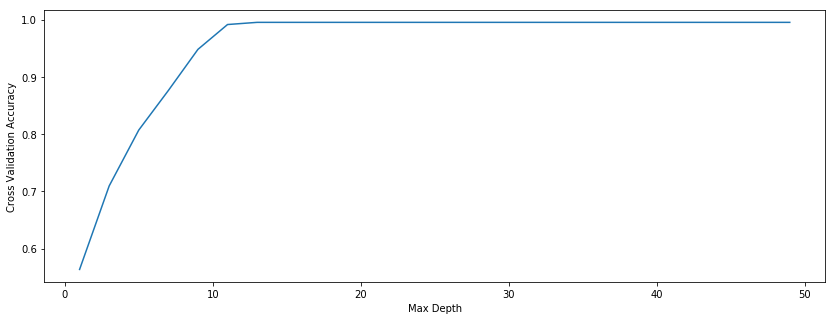

In [66]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Max Depth')

Text(0.5, 0, 'Max Depth')

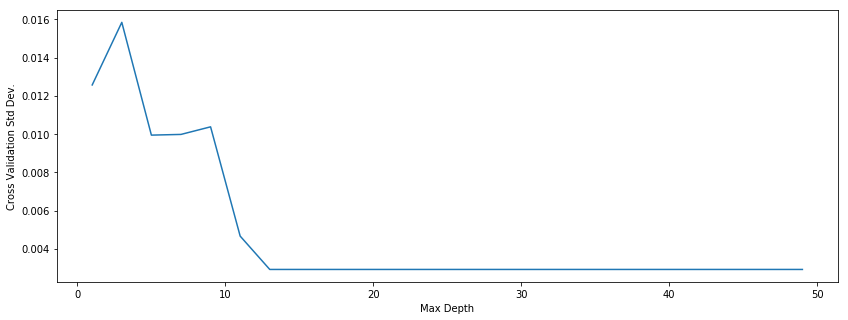

In [67]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Max Depth')

#### Model Performance